## Imports and Dataframe Loading

In [1]:
import os, sys

PROJECT_ROOT = os.path.abspath(os.path.join(os.getcwd(), ".."))
if PROJECT_ROOT not in sys.path:
    sys.path.insert(0, PROJECT_ROOT)

from data.data_helpers import get_dataframe

/Users/alfiehofmann/cis5200-project/venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [14]:
from sklearn.model_selection import train_test_split, TimeSeriesSplit, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import matplotlib.pyplot as plt

In [3]:
df = get_dataframe()
df.head()

/Users/alfiehofmann/cis5200-project/venv/lib/python3.9/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'cds.climate.copernicus.eu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Skipping existing file /Users/alfiehofmann/cis5200-project/data/era5_tehachapi_2018_H1.nc
Skipping existing file /Users/alfiehofmann/cis5200-project/data/era5_tehachapi_2018_H2.nc
Skipping existing file /Users/alfiehofmann/cis5200-project/data/era5_tehachapi_2019_H1.nc
Skipping existing file /Users/alfiehofmann/cis5200-project/data/era5_tehachapi_2019_H2.nc
Skipping existing file /Users/alfiehofmann/cis5200-project/data/era5_tehachapi_2020_H1.nc
Skipping existing file /Users/alfiehofmann/cis5200-project/data/era5_tehachapi_2020_H2.nc


,datetime,u10,v10,t2m,sp,hour_sin,hour_cos,month_sin,month_cos,doy_sin,doy_cos,wind_speed,target_next_hour
0,2018-01-01 00:00:00,-0.808231,-0.069685,291.890625,89925.2500,0.000000,1.000000,0.5,0.866025,0.017213,0.999852,0.811229,1.524293
1,2018-01-01 01:00:00,-1.340298,-0.725997,290.692627,89972.2500,0.258819,0.965926,0.5,0.866025,0.017213,0.999852,1.524293,1.245654
2,2018-01-01 02:00:00,-0.462882,-1.156458,288.544922,90036.1875,0.500000,0.866025,0.5,0.866025,0.017213,0.999852,1.245654,1.053555
3,2018-01-01 03:00:00,0.300817,-1.009697,285.121826,90091.3125,0.707107,0.707107,0.5,0.866025,0.017213,0.999852,1.053555,1.122294
4,2018-01-01 04:00:00,0.736362,-0.846944,283.715820,90125.1250,0.866025,0.500000,0.5,0.866025,0.017213,0.999852,1.122294,1.363163


## Simple Random Forest Model

In [4]:
feature_cols = [c for c in df.columns if c not in ["datetime", "target_next_hour"]]
X = df[feature_cols]
y = df["target_next_hour"]

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.


In [6]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False
)

# Define the model
rf = RandomForestRegressor(
    n_estimators=300,
    max_depth=None,
    min_samples_split=2,
    random_state=101,
    n_jobs=-1
)

# Train the model
rf.fit(X_train, y_train)

# Predictions
y_pred = rf.predict(X_test)

# Evaluation
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print("RMSE:", rmse)
print("R²:", r2)

Random Forest Results
----------------------
RMSE: 0.3275676944859179
R²: 0.9393621352163367


## More Complex Random Forest Training

In [7]:
n_samples = len(X)
train_size = int(n_samples * 0.8)

X_train, X_test = X.iloc[:train_size], X.iloc[train_size:]
y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]

In [8]:
# Base model
rf_base = RandomForestRegressor(
    n_estimators=300,
    max_depth=None,
    min_samples_split=2,
    random_state=101,
    n_jobs=-1
)

tscv = TimeSeriesSplit(n_splits=5)

cv_rmse_scores = []
cv_r2_scores = []

fold = 1
for train_idx, val_idx in tscv.split(X_train):
    X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]
    
    rf_base.fit(X_tr, y_tr)
    y_val_pred = rf_base.predict(X_val)
    
    rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
    r2 = r2_score(y_val, y_val_pred)
    
    cv_rmse_scores.append(rmse)
    cv_r2_scores.append(r2)
    
    print(f"Fold {fold}: RMSE={rmse:.4f}, R²={r2:.4f}")
    fold += 1

print("\nCV Summary (Baseline RF)")
print(f"Mean RMSE: {np.mean(cv_rmse_scores):.4f} ± {np.std(cv_rmse_scores):.4f}")
print(f"Mean R²:   {np.mean(cv_r2_scores):.4f} ± {np.std(cv_r2_scores):.4f}")


Fold 1: RMSE=0.4233, R²=0.8792
Fold 2: RMSE=0.4498, R²=0.8949
Fold 3: RMSE=0.4071, R²=0.9191
Fold 4: RMSE=0.3773, R²=0.9183
Fold 5: RMSE=0.4011, R²=0.9253

CV Summary (Baseline RF)
Mean RMSE: 0.4117 ± 0.0241
Mean R²:   0.9073 ± 0.0175


In [16]:
# Hyperparameter search space
param_dist = {
    "n_estimators": [200, 400, 600],
    "max_depth": [None, 10, 20, 40],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
    "max_features": ["sqrt", "log2", None]
}

rf = RandomForestRegressor(random_state=42, n_jobs=-1)

search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    n_iter=20,  # you can increase for a more thorough search
    cv=tscv,    # TimeSeriesSplit on TRAIN ONLY
    scoring="neg_root_mean_squared_error",
    random_state=42,
    n_jobs=-1,
    verbose=1
)

search.fit(X_train, y_train)

print("\nBest CV RMSE (neg):", search.best_score_)
print("Best params:", search.best_params_)


Fitting 5 folds for each of 20 candidates, totalling 100 fits


/Users/alfiehofmann/cis5200-project/venv/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(



Best CV RMSE (neg): -0.40844398792318437
Best params: {'n_estimators': 400, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': None, 'max_depth': 20}


In [12]:
best_rf = search.best_estimator_
best_rf.fit(X_train, y_train)

y_pred = best_rf.predict(X_test)

test_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
test_r2 = r2_score(y_test, y_pred)

print("\nFinal Test Performance (Best RF)")
print("--------------------------------")
print("Test RMSE:", test_rmse)
print("Test R²:", test_r2)



Final Test Performance (Best RF)
--------------------------------
Test RMSE: 0.3251683972207988
Test R²: 0.9402471763546296


### Visualizations

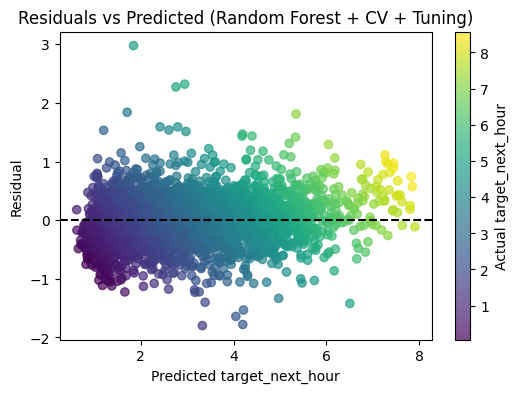

In [15]:
residuals = y_test - y_pred

plt.figure(figsize=(6,4))
plt.scatter(y_pred, residuals, c=y_test, cmap='viridis', alpha=0.7)
plt.axhline(0, linestyle="--", color="black")
plt.colorbar(label="Actual target_next_hour")
plt.xlabel("Predicted target_next_hour")
plt.ylabel("Residual")
plt.title("Residuals vs Predicted (Random Forest + CV + Tuning)")
plt.show()